Here, we will merely perform a paired t-test / wilcoxon test to test the differences between the age-sex matched subjects.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Perform-standard-paired-statistical-analysis-on-the-metabolomics-datasets." data-toc-modified-id="Perform-standard-paired-statistical-analysis-on-the-metabolomics-datasets.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Perform standard paired statistical analysis on the metabolomics datasets.</a></span><ul class="toc-item"><li><span><a href="#Needham" data-toc-modified-id="Needham-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Needham</a></span></li><li><span><a href="#Kuwabara" data-toc-modified-id="Kuwabara-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Kuwabara</a></span></li><li><span><a href="#Kang-2020" data-toc-modified-id="Kang-2020-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Kang 2020</a></span></li></ul></li><li><span><a href="#Compare-against-metabolic-network-from-cross-sectional-cohort." data-toc-modified-id="Compare-against-metabolic-network-from-cross-sectional-cohort.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare against metabolic network from cross-sectional cohort.</a></span></li></ul></div>

In [1]:
import os
import biom
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon, ttest_rel, mannwhitneyu, ttest_ind
from matplotlib_venn import venn2, venn3
import seaborn as sns
%matplotlib inline


def standard_test(data, group, reference=None, func=mannwhitneyu, mean_norm=False):
    """ Performs standard statistical test"""
    if mean_norm:
        med = data.mean(axis=1)
        data = data / data.mean(axis=1).values.reshape(-1, 1)
    if reference is None:
        reference = group.values[0]
    # extract groups
    groups = (group == reference)
    groupA, groupB = data.loc[groups], data.loc[~groups]
    def _func(feature_id):
        if np.allclose(groupA[feature_id].values, groupB[feature_id].values):
            return 1
        else:
            _, p = func(groupA[feature_id].values, groupB[feature_id].values)
        return p
    pvalues = list(map(_func, data.columns))
    corrected_pvals = multipletests(pvalues, method='fdr_bh')[1]
    return pd.DataFrame({'pvalues': pvalues, 'corrected_pvalues': corrected_pvals}, 
                         index=data.columns)    
    
def paired_test(data, matchings, group, reference=None, func=wilcoxon, mean_norm=False):
    """ Performs paired testing
    
    Parameters
    ----------
    data : pd.DataFrame
        Table of counts (samples x features)
    matchings : pd.Series
        Matching assignments
    group : pd.Series
        Treatment assignments
    func : callable
        The paired statistical test to perform. The paired test
        must return a statistic and a pvalue
    median_norm : bool
        If specified, this will rescale the data around the median
    """
    if mean_norm:
        med = data.mean(axis=1)
        data = data / data.mean(axis=1).values.reshape(-1, 1)
        
    if reference is None:
        reference = group.values[0]
    # extract groups
    groups = (group == reference)
    groupA, groupB = data.loc[groups], data.loc[~groups]
    # pull out matchings and sort them
    matchingA = matchings.loc[groupA.index].sort_values()
    matchingB = matchings.loc[groupB.index].sort_values()
    # order groups by their match id
    groupA = groupA.loc[matchingA.index]
    groupB = groupB.loc[matchingB.index]
    # perform paired test
    def _paired_func(feature_id):
        if np.allclose(groupA[feature_id].values, groupB[feature_id].values):
            return 1
        else:
            _, p = func(groupA[feature_id].values, groupB[feature_id].values)
        return p
    pvalues = list(map(_paired_func, data.columns))
    corrected_pvals = multipletests(pvalues, method='fdr_bh')[1]
    return pd.DataFrame({'pvalues': pvalues, 'corrected_pvalues': corrected_pvals}, 
                         index=data.columns)


def fetch_keggs_from_names(pvalues, column = 'pvalues', alpha=0.05):
    url = r'http://cts.fiehnlab.ucdavis.edu/service/convert/Chemical Name/KEGG/%s'
    pairs = []
    for i, n in enumerate(pvalues.index):
        u = url % n
        if pvalues.loc[n, column] > alpha: continue
        try:
            response = requests.get(u)
            d = response.json()
            for k in d[0]['result']:
                pairs.append((n, k))
        except:
            continue
    return pairs
    
data_dir = '~/ceph/sfari/data/metabolomics'

# Perform standard paired statistical analysis on the metabolomics datasets.

In [2]:
noto_md = pd.read_table(
    os.path.join(data_dir, 'Noto2014', 'urine_sample_metadata.txt'), 
    index_col=0, comment='#')
noto_table = biom.load_table('../sfari/data/metabolomics/Noto2014/urine.biom')
noto_table = noto_table.to_dataframe().T

pvalues = paired_test(noto_table, 
                      noto_md['Match_IDs'], 
                      noto_md['Status'], reference='Control', 
                      func=wilcoxon)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
Tryptophan,0.000697,0.060677
Cystine,0.001567,0.060677
Leucine,0.001863,0.060677
Quinic acid,0.002225,0.060677
3-Aminoisobutyric acid,0.002615,0.060677
Uric acid,0.006833,0.131781
Tyrosine,0.007952,0.131781
Succinic acid,0.012814,0.150270
1-Methylhistidine,0.013275,0.150270
3-Deoxy-2 4 5-trihydroxypentonic acid,0.014250,0.150270


In [3]:
lookup = fetch_keggs_from_names(pvalues)

In [4]:
lookup = pd.DataFrame(lookup, columns=['Compound_Name', 'KEGG'])
pvalues = pd.merge(pvalues, lookup, left_index=True, right_on='Compound_Name')
pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/noto2014_urine_pvalues.csv')

## Needham

In [5]:
needham_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'plasma_sample_metadata.txt'), 
    index_col=0, comment='#')
needham_table = biom.load_table('../sfari/data/metabolomics/Needham2020/plasma.biom')
needham_table = needham_table.to_dataframe().T
plasma_metabolite_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'plasma_metabolite_metadata.txt'), 
    index_col=0)

pvalues = paired_test(needham_table, 
                      needham_md['Match_IDs'], 
                      needham_md['Status'], reference='Control', 
                      func=wilcoxon, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,pvalues,corrected_pvalues
Total CE,0.000108,0.048648
DAG(16:1/18:1),0.000108,0.048648
LPC(14:0),0.000114,0.048648
DAG(16:1/18:0),0.000121,0.048648
CE(18:1),0.000186,0.048648
DAG(14:1/18:1),0.000207,0.048648
CE(20:1),0.000219,0.048648
CE(18:2),0.000270,0.048648
DAG(14:0/18:1),0.000284,0.048648
LPC(15:0),0.000332,0.048648


In [6]:
plasma_metabolite_md = plasma_metabolite_md.set_index('BIOCHEMICAL')
pvalues = pd.merge(pvalues, plasma_metabolite_md, left_index=True, right_index=True)
pvalues = pvalues.dropna(subset=['KEGG'])
pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/needham2020_plasma_pvalues.csv')

In [7]:
pvalues = standard_test(needham_table, 
                        needham_md['Status'], reference='Control', 
                        func=mannwhitneyu, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
DAG(16:1/18:1),0.000005,0.007550
DAG(14:1/18:1),0.000014,0.007793
CE(18:3),0.000015,0.007793
LPC(17:0),0.000024,0.008208
Total CE,0.000026,0.008208
TAG53:6-FA18:2,0.000031,0.008208
TAG44:0-FA18:0,0.000036,0.008208
LPC(20:3),0.000042,0.008208
LPC(14:0),0.000046,0.008208
LPC(18:3),0.000071,0.011390


In [8]:
needham_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'fecal_sample_metadata.txt'), 
    index_col=0, comment='#')
needham_table = biom.load_table('../sfari/data/metabolomics/Needham2020/fecal.biom')
needham_table = needham_table.to_dataframe().T
fecal_metabolite_md = pd.read_table(
    os.path.join(data_dir, 'Needham2020', 'fecal_metabolite_metadata.txt'), 
    index_col=0)

pvalues = paired_test(needham_table, 
                      needham_md['Match_IDs'], 
                      needham_md['Status'], reference='Control', 
                      func=wilcoxon, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,pvalues,corrected_pvalues
retinol (Vitamin A),0.001021,0.831322
3-aminoisobutyrate,0.004286,0.971272
I-urobilinogen,0.005723,0.971272
aconitate [cis or trans],0.007443,0.971272
"uridine-2',3'-cyclic monophosphate",0.009882,0.971272
hydroxymethylpyrimidine,0.011473,0.971272
1-palmitoleoylglycerol (16:1)*,0.014095,0.971272
"2,4-dihydroxyhydrocinnamate",0.020858,0.971272
nicotinamide,0.020858,0.971272
1-oleoyl-GPC (18:1),0.022916,0.971272


In [9]:
fecal_metabolite_md = fecal_metabolite_md.set_index('BIOCHEMICAL')
pvalues = pd.merge(pvalues, fecal_metabolite_md, left_index=True, right_index=True)
pvalues = pvalues.dropna(subset=['KEGG'])
pvalues = pvalues.loc[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/needham2020_fecal_pvalues.csv')

In [10]:
pvalues = standard_test(needham_table, 
                        needham_md['Status'], reference='Control', 
                        func=mannwhitneyu, mean_norm=True)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
retinol (Vitamin A),0.000095,0.077478
1-methylurate,0.002173,0.479931
glutamyl-meso-diaminopimelate,0.002947,0.479931
1-oleoyl-GPC (18:1),0.004742,0.479931
1-palmitoleoylglycerol (16:1)*,0.005076,0.479931
1-linoleoyl-GPE (18:2)*,0.005746,0.479931
hydroxymethylpyrimidine,0.006635,0.479931
alpha-tocotrienol,0.007086,0.479931
"uridine-2',3'-cyclic monophosphate",0.007956,0.479931
aconitate [cis or trans],0.008063,0.479931


## Kuwabara

In [11]:
kuwabara_md = pd.read_table(
    os.path.join(data_dir, 'Kuwabara2013', 'plasma_sample_metadata.txt'), 
    index_col=0, comment='#')
kuwabara_table = biom.load_table('../sfari/data/metabolomics/Kuwabara2013/plasma.biom')
kuwabara_table = kuwabara_table.to_dataframe().T

pvalues = paired_test(kuwabara_table, 
                      kuwabara_md['Match_IDs'], 
                      kuwabara_md['Status'], reference='Control', 
                      func=wilcoxon)
pvalues.sort_values('corrected_pvalues').head(10)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,pvalues,corrected_pvalues
C00334,0.001953,0.218750
C00022,0.013672,0.282912
"C00186,C00256,C01432",0.005859,0.282912
"C00049,C00402,C16433",0.009766,0.282912
C00327,0.013672,0.282912
C00008,0.015156,0.282912
"C00025,C00217,C00302",0.037109,0.415625
C00093,0.037109,0.415625
"C00065,C00716,C00740",0.037109,0.415625
"C00062,C00792",0.037109,0.415625


In [12]:
pairs = []
for i, x in enumerate(pvalues.index):
    for k in x.split(','):
        pairs.append((i, k))

pairs = pd.DataFrame(pairs, columns=['idx', 'KEGG'])
pvalues = pvalues.reset_index()
pvalues = pd.merge(pvalues, pairs, left_index=True, right_on='idx')
pvalues = pvalues[pvalues.pvalues < 0.05]
pvalues.to_csv('../results/metabolomics/kuwabara2013_plasma_pvalues.csv')

In [13]:
pvalues = standard_test(kuwabara_table, 
                        kuwabara_md['Status'], reference='Control', 
                        func=mannwhitneyu)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
"C00049,C00402,C16433",0.000384,0.043038
C00327,0.002293,0.128419
"C00186,C00256,C01432",0.003642,0.135978
C00008,0.006033,0.138060
C00022,0.007010,0.138060
C00334,0.008545,0.138060
"C00025,C00217,C00302",0.008629,0.138060
"C00062,C00792",0.010567,0.147937
C00002,0.017492,0.217673
C01601,0.060612,0.605080


## Kang 2020

Relevant paper https://pubmed.ncbi.nlm.nih.gov/33087514/

In [14]:
kang_md = pd.read_table(
    os.path.join(data_dir, 'Kang2018', 'fecal_sample_metadata.txt'), 
    index_col=0, comment='#')
kang_table = biom.load_table('../sfari/data/metabolomics/Kang2018/fecal.biom')
kang_table = kang_table.to_dataframe().T

pvalues = paired_test(kang_table, 
                      kang_md['Match_IDs'], 
                      kang_md['Status'], reference='Neurotypical', 
                      func=wilcoxon)
pvalues.sort_values('pvalues').head(10)

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,pvalues,corrected_pvalues
Isopropanol,0.019473,0.780492
Isovalerate,0.045993,0.780492
p-Cresol,0.050192,0.780492
Formate,0.054693,0.780492
Fumarate,0.075980,0.780492
Phenylacetate,0.082195,0.780492
Taurine,0.092601,0.780492
Lactate,0.111058,0.819054
Isobutyrate,0.167807,0.891491
Caprate,0.228986,0.891491


In [15]:
lookup = fetch_keggs_from_names(pvalues)
lookup = pd.DataFrame(lookup, columns=['Compound_Name', 'KEGG'])
pvalues = pd.merge(pvalues, lookup, left_index=True, right_on='Compound_Name')
pvalues.to_csv('../results/metabolomics/kang2018_fecal_pvalues.csv')

In [16]:
pvalues = standard_test(kang_table, 
                        kang_md['Status'], reference='Neurotypical', 
                        func=mannwhitneyu)
pvalues.sort_values('pvalues').head(10)

,pvalues,corrected_pvalues
Isopropanol,0.000490,0.028922
Lactate,0.007529,0.222107
Formate,0.014315,0.255129
p-Cresol,0.017297,0.255129
Isovalerate,0.051012,0.362669
Fumarate,0.053702,0.362669
Glycerol,0.056505,0.362669
Trimethylamine,0.056505,0.362669
Phenylacetate,0.065605,0.362669
Isobutyrate,0.065605,0.362669


# Compare against metabolic network from cross-sectional cohort.

In [17]:
new_pos = pd.read_csv('../results/connected_compound_positions.csv', index_col=0)
rna_compounds = pd.read_csv('../results/RNA_compounds.csv', index_col=0)
wgs_compounds = pd.read_csv('../results/WGS_compounds.csv', index_col=0)
amp_compounds = pd.read_csv('../results/16S_compounds.csv', index_col=0)

rna_logpvals = rna_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
wgs_logpvals = wgs_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()
amp_logpvals = amp_compounds[['Compound', '-log(pvalue)']].groupby('Compound').mean()

wgs_pos = pd.merge(new_pos, wgs_logpvals, left_index=True, right_index=True)
amp_pos = pd.merge(new_pos, amp_logpvals, left_index=True, right_index=True)
rna_pos = pd.merge(new_pos, rna_logpvals, left_index=True, right_index=True)

all_pos = pd.concat((wgs_pos, amp_pos, rna_pos))
all_pos = all_pos.reset_index()
all_pos = all_pos.groupby('index').mean()

In [18]:
# load all differential abundance tests
noto_pvalues = pd.read_csv('../results/metabolomics/noto2014_urine_pvalues.csv', index_col=0)
kuwabara_pvalues = pd.read_csv('../results/metabolomics/kuwabara2013_plasma_pvalues.csv', index_col=0)
kang_plasma_pvalues = pd.read_csv('../results/metabolomics/kang2018_fecal_pvalues.csv', index_col=0)
nd_fecal_pvalues = pd.read_csv('../results/metabolomics/needham2020_fecal_pvalues.csv', index_col=0)
nd_plasma_pvalues = pd.read_csv('../results/metabolomics/needham2020_plasma_pvalues.csv', index_col=0)

noto_pvalues['dataset'] = 'Noto'
kuwabara_pvalues['dataset'] = 'Kuwabara'
nd_fecal_pvalues['dataset'] = 'Needham'
nd_plasma_pvalues['dataset'] = 'Needham'
kang_plasma_pvalues['dataset'] = 'Kang'

noto_pvalues['sample_type'] = 'Urine'
kuwabara_pvalues['sample_type'] = 'Plasma'
nd_fecal_pvalues['sample_type'] = 'Fecal'
nd_plasma_pvalues['sample_type'] = 'Plasma'
kang_plasma_pvalues['sample_type'] = 'Fecal'

all_pvalues = pd.concat((noto_pvalues, kuwabara_pvalues, 
                         nd_fecal_pvalues, nd_plasma_pvalues, 
                         kang_plasma_pvalues))
all_pvalues = all_pvalues[['pvalues', 'corrected_pvalues', 'Compound_Name', 
                           'KEGG', 'dataset', 'sample_type']]

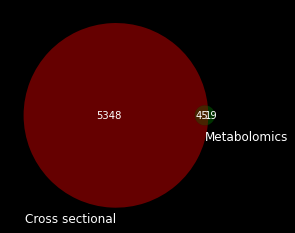

In [19]:
with plt.style.context('dark_background'):
    venn2([set(all_pos.index), set(all_pvalues['KEGG'])], ['Cross sectional', 'Metabolomics'])

In [20]:
all_pos = pd.merge(all_pvalues, all_pos, left_on='KEGG', right_index=True, how='right')
all_pos = all_pos.set_index('KEGG')

In [21]:
def pvalue_f(x):
    if pd.isnull(x):
        return 'Cross-sectional'
    if x < 0.05:
        return 'FDR significant'
    else:
        return 'Reported'
all_pos['Signficance'] = all_pos.corrected_pvalues.apply(pvalue_f)
sub_pos = all_pos.dropna(subset=['sample_type'])

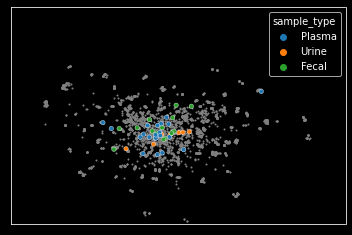

In [22]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.scatter(all_pos['0'], all_pos['1'], s=1, c='gray')
    sns.scatterplot(data=sub_pos, x='0', y='1', hue='sample_type',
                    s=20, palette='tab10', ax=ax)
    ax.set_xlim([-0.11, 0.15])
    ax.set_ylim([-0.11, 0.15])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')    

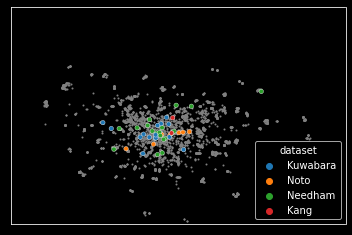

In [23]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots()
    ax.scatter(all_pos['0'], all_pos['1'], s=1, c='gray')
    sns.scatterplot(data=sub_pos, x='0', y='1', hue='dataset',
                    s=20, palette='tab10', ax=ax)
    ax.set_xlim([-0.11, 0.15])
    ax.set_ylim([-0.11, 0.15])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')    